In [67]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import backend
import glob

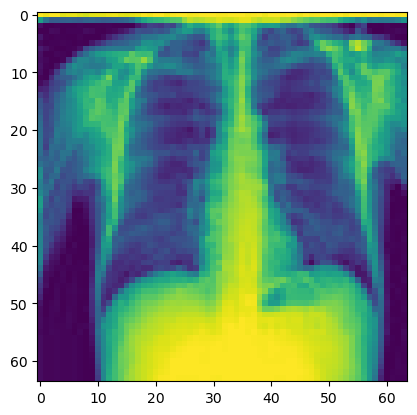

In [2]:
im = plt.imread('/kaggle/input/medical-mnist/CXR/000000.jpeg')
plt.imshow(im);

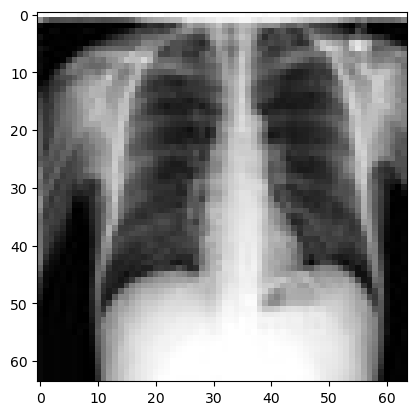

In [3]:
plt.imshow(im, 'gray');

In [4]:
im.shape

(64, 64)

## Importando os arquivos:

In [5]:
files = glob.glob('/kaggle/input/medical-mnist/**/*.jpeg', recursive = True)

In [6]:
len(files)

58954

In [7]:
df = pd.DataFrame({'path': files})
df.head()

,path
0,/kaggle/input/medical-mnist/AbdomenCT/003646.jpeg
1,/kaggle/input/medical-mnist/AbdomenCT/003998.jpeg
2,/kaggle/input/medical-mnist/AbdomenCT/001273.jpeg
3,/kaggle/input/medical-mnist/AbdomenCT/001609.jpeg
4,/kaggle/input/medical-mnist/AbdomenCT/007646.jpeg


In [8]:
df['path'][0]

'/kaggle/input/medical-mnist/AbdomenCT/003646.jpeg'

In [9]:
df['class'] = df['path'].apply(lambda x: x.split('/')[4])
df.head()

,path,class
0,/kaggle/input/medical-mnist/AbdomenCT/003646.jpeg,AbdomenCT
1,/kaggle/input/medical-mnist/AbdomenCT/003998.jpeg,AbdomenCT
2,/kaggle/input/medical-mnist/AbdomenCT/001273.jpeg,AbdomenCT
3,/kaggle/input/medical-mnist/AbdomenCT/001609.jpeg,AbdomenCT
4,/kaggle/input/medical-mnist/AbdomenCT/007646.jpeg,AbdomenCT


In [10]:
df['class'].value_counts()

AbdomenCT    10000
Hand         10000
CXR          10000
HeadCT       10000
ChestCT      10000
BreastMRI     8954
Name: class, dtype: int64

## Separando Treino e Teste:

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['path'] , df['class'], test_size = 0.1)
len(X_train)

53058

In [13]:
len(X_test)

5896

In [14]:
BATCH_SIZE = 128

In [15]:
data_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.15)

In [16]:
df_train = pd.concat([X_train, y_train], axis = 1)
df_train.head()

,path,class
11082,/kaggle/input/medical-mnist/BreastMRI/002830.jpeg,BreastMRI
19746,/kaggle/input/medical-mnist/Hand/006512.jpeg,Hand
50186,/kaggle/input/medical-mnist/ChestCT/009134.jpeg,ChestCT
29944,/kaggle/input/medical-mnist/CXR/004058.jpeg,CXR
39988,/kaggle/input/medical-mnist/HeadCT/000555.jpeg,HeadCT


## Definição da arquitetura:

In [17]:
train_generator = data_generator.flow_from_dataframe(dataframe = df_train, x_col = 'path', y_col = 'class', 
                                                     class_mode = 'categorical', batch_size = BATCH_SIZE, 
                                                     target_size = (64,64), subset = 'training', 
                                                     color_mode = 'grayscale')

Found 45100 validated image filenames belonging to 6 classes.


In [18]:
valid_generator = data_generator.flow_from_dataframe(dataframe = df_train, x_col = 'path', y_col = 'class', 
                                                     class_mode = 'categorical', batch_size = BATCH_SIZE, 
                                                     target_size = (64,64), subset = 'validation', 
                                                     color_mode = 'grayscale')

Found 7958 validated image filenames belonging to 6 classes.


In [19]:
def build_model():

    model = Sequential()

    model.add(layers.Conv2D(filters = 32, kernel_size = 2, activation = "relu", input_shape = (64, 64, 1)))
    model.add(layers.MaxPooling2D(pool_size = 2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    model.add(layers.Dense(28, activation = 'relu'))
    model.add(layers.Dense(6, activation = 'softmax'))

    return model

In [20]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 28)                861084    
                                                                 
 dense_1 (Dense)             (None, 6)                 174       
                                                        

## Compilação:

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [22]:
checkpoint = ModelCheckpoint('medical_image_model.hdf5', monitor = 'val_loss', verbose = 1, mode = 'min', 
                             save_best_only = True)

In [23]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5, mode = 'min', verbose = 1)

## Treinamento:

In [24]:
model.fit(train_generator, callbacks = [checkpoint, early_stop], steps_per_epoch = train_generator.samples//BATCH_SIZE, 
          validation_data = valid_generator, validation_steps = valid_generator.samples//BATCH_SIZE, epochs = 25)

Epoch 1/25
352/352 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 0.9751
Epoch 1: val_loss improved from inf to 0.00857, saving model to medical_image_model.hdf5
352/352 [==============================] - 422s 1s/step - loss: 0.0849 - accuracy: 0.9751 - val_loss: 0.0086 - val_accuracy: 0.9982
Epoch 2/25
352/352 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9976
Epoch 2: val_loss improved from 0.00857 to 0.00342, saving model to medical_image_model.hdf5
352/352 [==============================] - 92s 260ms/step - loss: 0.0101 - accuracy: 0.9976 - val_loss: 0.0034 - val_accuracy: 0.9990
Epoch 3/25
352/352 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9988
Epoch 3: val_loss did not improve from 0.00342
352/352 [==============================] - 92s 260ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0084 - val_accuracy: 0.9970
Epoch 4/25
352/352 [==============================] - ETA: 0s - loss: 0.0034 - accu

In [25]:
model

In [26]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [27]:
test_imgs = [img_to_array(load_img(im_path, color_mode = "grayscale")) for im_path in X_test]

In [28]:
y_pred = model.predict(np.array(test_imgs))

185/185 [==============================] - 2s 12ms/step


In [29]:
y_pred.argmax(axis = 1)

array([3, 4, 4, ..., 3, 3, 3])

## Avaliação:

In [30]:
from sklearn.metrics import confusion_matrix

In [33]:
y_test.values

array(['ChestCT', 'Hand', 'Hand', ..., 'AbdomenCT', 'HeadCT', 'HeadCT'],
      dtype=object)

In [50]:
y_test.head(10)

52591      ChestCT
20179         Hand
21537         Hand
1140     AbdomenCT
14377    BreastMRI
41465       HeadCT
18664    BreastMRI
39912       HeadCT
50430      ChestCT
15868    BreastMRI
Name: class, dtype: object

In [62]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['ChestCT', 'Hand', 'AbdomenCT', 'BreastMRI', 'HeadCT', 'CXR'])

LabelEncoder()

In [63]:
y_teste = le.fit_transform(y_test)
y_teste

array([3, 4, 4, ..., 0, 5, 5])

In [65]:
cm = confusion_matrix(y_teste, y_pred.argmax(axis = 1))
cm

array([[   0,    0,    0,  967,    0,    0],
       [ 163,  409,   35,  256,   99,    0],
       [   0,    0,  962,    6,    2,    0],
       [   0,    0,    0, 1016,    0,    0],
       [   0,    0,   12,   21,  957,    0],
       [   0,    0,    7,  353,  631,    0]])

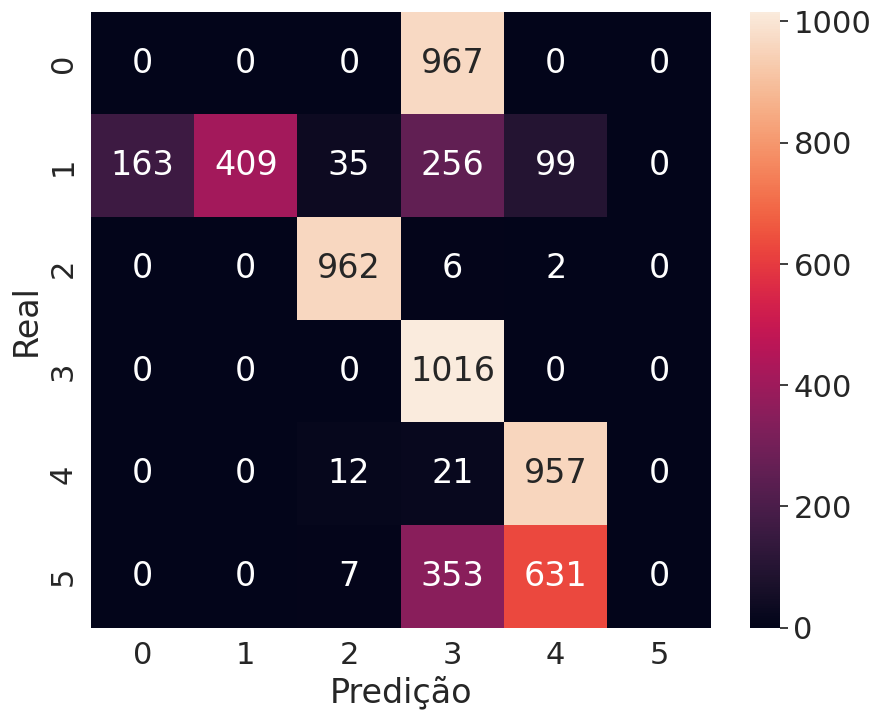

In [66]:
import seaborn as sns

plt.figure(figsize = (10, 8))
sns.set(font_scale = 2)
sns.heatmap(cm, annot = True, fmt = "d").set(xlabel = "Predição", ylabel = "Real");